In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [25]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [26]:
y.shape

(144, 2)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(100, 113)

In [29]:
y_train.shape

(100, 2)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 2)                 258   

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221124"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)

In [35]:
## Setting up callbacks
checkpoint_name = model_directory + '\\20221124ModelCheckpoint_MLP_test'+str(test_rate)+'.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only=True,
                                          monitor='loss', mode='min')
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=200, factor=0.5,
                                          min_delta = 1e-08, min_lr=1e-08,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=10000, callbacks=[es, ckpt,rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 1s 12ms/step - loss: 0.6353 - rmse: 0.7971 - lr: 0.0010
Epoch 2/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.2395 - rmse: 0.4894 - lr: 0.0010
Epoch 3/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.1384 - rmse: 0.3721 - lr: 0.0010
Epoch 4/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0680 - rmse: 0.2608 - lr: 0.0010
Epoch 5/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0691 - rmse: 0.2629 - lr: 0.0010
Epoch 6/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.0444 - rmse: 0.2108 - lr: 0.0010
Epoch 7/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0299 - rmse: 0.1730 - lr: 0.0010
Epoch 8/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0235 - rmse: 0.1533 - lr: 0.0010
Epoch 9/10000
5/5 [==============================] - 0s 14ms/step - loss: 0.0196 - rmse: 0.1401 - lr: 0.0010
Epoch 10/10000
5/5 [

5/5 [==============================] - 0s 3ms/step - loss: 0.0010 - rmse: 0.0321 - lr: 0.0010
Epoch 76/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0014 - rmse: 0.0371 - lr: 0.0010
Epoch 77/10000
5/5 [==============================] - 0s 14ms/step - loss: 9.2907e-04 - rmse: 0.0305 - lr: 0.0010
Epoch 78/10000
5/5 [==============================] - 0s 3ms/step - loss: 9.3715e-04 - rmse: 0.0306 - lr: 0.0010
Epoch 79/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0010 - rmse: 0.0323 - lr: 0.0010
Epoch 80/10000
5/5 [==============================] - 0s 14ms/step - loss: 8.2714e-04 - rmse: 0.0288 - lr: 0.0010
Epoch 81/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0012 - rmse: 0.0351 - lr: 0.0010
Epoch 82/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0333 - lr: 0.0010
Epoch 83/10000
5/5 [==============================] - 0s 3ms/step - loss: 8.3744e-04 - rmse: 0.0289 - lr: 0.0010
Epoch 84/10000
5

5/5 [==============================] - 0s 5ms/step - loss: 6.7232e-04 - rmse: 0.0259 - lr: 0.0010
Epoch 148/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.3617e-04 - rmse: 0.0252 - lr: 0.0010
Epoch 149/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.1523e-04 - rmse: 0.0204 - lr: 0.0010
Epoch 150/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.4068e-04 - rmse: 0.0185 - lr: 0.0010
Epoch 151/10000
5/5 [==============================] - 0s 18ms/step - loss: 1.7144e-04 - rmse: 0.0131 - lr: 0.0010
Epoch 152/10000
5/5 [==============================] - 0s 17ms/step - loss: 1.3293e-04 - rmse: 0.0115 - lr: 0.0010
Epoch 153/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.3244e-04 - rmse: 0.0115 - lr: 0.0010
Epoch 154/10000
5/5 [==============================] - 0s 16ms/step - loss: 1.0266e-04 - rmse: 0.0101 - lr: 0.0010
Epoch 155/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0544e-04 - rmse: 0.0103

Epoch 219/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.7710e-04 - rmse: 0.0240 - lr: 0.0010
Epoch 220/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.6199e-04 - rmse: 0.0215 - lr: 0.0010
Epoch 221/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.9338e-04 - rmse: 0.0263 - lr: 0.0010
Epoch 222/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.3709e-04 - rmse: 0.0306 - lr: 0.0010
Epoch 223/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.7782e-04 - rmse: 0.0279 - lr: 0.0010
Epoch 224/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0362 - lr: 0.0010
Epoch 225/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0438 - lr: 0.0010
Epoch 226/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.5833e-04 - rmse: 0.0293 - lr: 0.0010
Epoch 227/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.3458e-04 - rmse: 0.

Epoch 291/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9496e-04 - rmse: 0.0172 - lr: 0.0010
Epoch 292/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3771e-04 - rmse: 0.0154 - lr: 0.0010
Epoch 293/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9037e-04 - rmse: 0.0138 - lr: 0.0010
Epoch 294/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1704e-04 - rmse: 0.0147 - lr: 0.0010
Epoch 295/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3419e-04 - rmse: 0.0116 - lr: 0.0010
Epoch 296/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.1649e-05 - rmse: 0.0096 - lr: 0.0010
Epoch 297/10000
5/5 [==============================] - 0s 6ms/step - loss: 9.2631e-05 - rmse: 0.0096 - lr: 0.0010
Epoch 298/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.1170e-04 - rmse: 0.0106 - lr: 0.0010
Epoch 299/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1654e-04 - 

5/5 [==============================] - 0s 5ms/step - loss: 1.2483e-05 - rmse: 0.0035 - lr: 0.0010
Epoch 363/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.9427e-05 - rmse: 0.0044 - lr: 0.0010
Epoch 364/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2369e-05 - rmse: 0.0047 - lr: 0.0010
Epoch 365/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.4415e-05 - rmse: 0.0059 - lr: 0.0010
Epoch 366/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.4703e-05 - rmse: 0.0059 - lr: 0.0010
Epoch 367/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5393e-05 - rmse: 0.0050 - lr: 0.0010
Epoch 368/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6357e-05 - rmse: 0.0040 - lr: 0.0010
Epoch 369/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8718e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 370/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9649e-05 - rmse: 0.0044 - l

5/5 [==============================] - 0s 5ms/step - loss: 9.6148e-04 - rmse: 0.0310 - lr: 0.0010
Epoch 435/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - rmse: 0.0578 - lr: 0.0010
Epoch 436/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0502 - lr: 0.0010
Epoch 437/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0465 - lr: 0.0010
Epoch 438/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0990 - lr: 0.0010
Epoch 439/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0083 - rmse: 0.0910 - lr: 0.0010
Epoch 440/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 0.0010
Epoch 441/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0061 - rmse: 0.0782 - lr: 0.0010
Epoch 442/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - rmse: 0.0619 - lr: 0.0010
Epoch 443/10000
5/5 [=

5/5 [==============================] - 0s 5ms/step - loss: 7.7517e-05 - rmse: 0.0088 - lr: 0.0010
Epoch 507/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.3467e-05 - rmse: 0.0080 - lr: 0.0010
Epoch 508/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.3488e-05 - rmse: 0.0086 - lr: 0.0010
Epoch 509/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2303e-04 - rmse: 0.0111 - lr: 0.0010
Epoch 510/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2275e-04 - rmse: 0.0149 - lr: 0.0010
Epoch 511/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7691e-04 - rmse: 0.0166 - lr: 0.0010
Epoch 512/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7011e-04 - rmse: 0.0130 - lr: 0.0010
Epoch 513/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5325e-04 - rmse: 0.0124 - lr: 0.0010
Epoch 514/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7099e-04 - rmse: 0.0131 - l

5/5 [==============================] - 0s 5ms/step - loss: 5.6098e-05 - rmse: 0.0075 - lr: 0.0010
Epoch 579/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7043e-05 - rmse: 0.0052 - lr: 0.0010
Epoch 580/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9659e-05 - rmse: 0.0054 - lr: 0.0010
Epoch 581/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.4336e-05 - rmse: 0.0049 - lr: 0.0010
Epoch 582/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6540e-05 - rmse: 0.0041 - lr: 0.0010
Epoch 583/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2689e-05 - rmse: 0.0036 - lr: 0.0010
Epoch 584/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6083e-05 - rmse: 0.0040 - lr: 0.0010
Epoch 585/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0220e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 586/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0607e-05 - rmse: 0.0033 - l

5/5 [==============================] - 0s 5ms/step - loss: 2.3938e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 647/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.4489e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 648/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.7170e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 649/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9323e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 650/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.4599e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 651/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7365e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 652/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1940e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 653/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6992e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 654/10000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 1.8097e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 716/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5143e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 717/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5109e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 718/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.0457e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 719/10000
5/5 [==============================] - 0s 6ms/step - loss: 2.6538e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 720/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.5824e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 721/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6217e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 722/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5709e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 723/10000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 1.5969e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 785/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7350e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 786/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5072e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 787/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.0508e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 788/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0666e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 789/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1498e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 790/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7197e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 791/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6778e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 792/10000
5/5 [==============================] - 0s 5ms/step - los

Epoch 853/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6609e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 854/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4340e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 855/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2019e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 856/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7730e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 857/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6473e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 858/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6109e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 859/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3252e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 860/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.7296e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 861/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 6.0611e-05 - rmse: 0.0078 - lr: 5.0000e-04
Epoch 923/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.0301e-05 - rmse: 0.0055 - lr: 5.0000e-04
Epoch 924/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5078e-05 - rmse: 0.0074 - lr: 5.0000e-04
Epoch 925/10000
5/5 [==============================] - 0s 6ms/step - loss: 4.7712e-05 - rmse: 0.0069 - lr: 5.0000e-04
Epoch 926/10000
5/5 [==============================] - 0s 6ms/step - loss: 3.8525e-05 - rmse: 0.0062 - lr: 5.0000e-04
Epoch 927/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1833e-05 - rmse: 0.0047 - lr: 5.0000e-04
Epoch 928/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2775e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 929/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5154e-05 - rmse: 0.0050 - lr: 5.0000e-04
Epoch 930/10000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 5.1854e-05 - rmse: 0.0072 - lr: 5.0000e-04
Epoch 992/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5150e-05 - rmse: 0.0074 - lr: 5.0000e-04
Epoch 993/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2484e-05 - rmse: 0.0057 - lr: 5.0000e-04
Epoch 994/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.0453e-05 - rmse: 0.0090 - lr: 5.0000e-04
Epoch 995/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.1008e-05 - rmse: 0.0084 - lr: 5.0000e-04
Epoch 996/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0996e-05 - rmse: 0.0071 - lr: 5.0000e-04
Epoch 997/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.7061e-05 - rmse: 0.0088 - lr: 5.0000e-04
Epoch 998/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.2809e-05 - rmse: 0.0079 - lr: 5.0000e-04
Epoch 999/10000
5/5 [==============================] - 0s 5ms/step - los

5/5 [==============================] - 0s 5ms/step - loss: 3.2487e-06 - rmse: 0.0018 - lr: 2.5000e-04
Epoch 1059/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9016e-06 - rmse: 0.0017 - lr: 2.5000e-04
Epoch 1060/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.4398e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1061/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3060e-06 - rmse: 0.0015 - lr: 2.5000e-04
Epoch 1062/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.6121e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1063/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.4621e-06 - rmse: 0.0016 - lr: 2.5000e-04
Epoch 1064/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0568e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1065/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3236e-06 - rmse: 0.0015 - lr: 2.5000e-04
Epoch 1066/10000
5/5 [==============================] - 0s 5ms/st

Epoch 1127/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7717e-06 - rmse: 0.0013 - lr: 2.5000e-04
Epoch 1128/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7322e-06 - rmse: 0.0013 - lr: 2.5000e-04
Epoch 1129/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5355e-06 - rmse: 0.0012 - lr: 2.5000e-04
Epoch 1130/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7743e-06 - rmse: 0.0013 - lr: 2.5000e-04
Epoch 1131/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9441e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1132/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8656e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1133/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6052e-06 - rmse: 0.0013 - lr: 2.5000e-04
Epoch 1134/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2132e-06 - rmse: 0.0011 - lr: 2.5000e-04
Epoch 1135/10000
5/5 [==========================

5/5 [==============================] - 0s 5ms/step - loss: 1.0606e-06 - rmse: 0.0010 - lr: 2.5000e-04
Epoch 1195/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.5020e-07 - rmse: 9.2206e-04 - lr: 2.5000e-04
Epoch 1196/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.1874e-07 - rmse: 9.5851e-04 - lr: 2.5000e-04
Epoch 1197/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.0495e-07 - rmse: 8.9719e-04 - lr: 2.5000e-04
Epoch 1198/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.3347e-07 - rmse: 7.9591e-04 - lr: 2.5000e-04
Epoch 1199/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.4058e-07 - rmse: 8.6057e-04 - lr: 2.5000e-04
Epoch 1200/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.0258e-07 - rmse: 7.7626e-04 - lr: 2.5000e-04
Epoch 1201/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9185e-07 - rmse: 7.6932e-04 - lr: 2.5000e-04
Epoch 1202/10000
5/5 [===============

Epoch 1261/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.3260e-07 - rmse: 9.1247e-04 - lr: 2.5000e-04
Epoch 1262/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.5044e-07 - rmse: 8.6628e-04 - lr: 2.5000e-04
Epoch 1263/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.4703e-07 - rmse: 8.0438e-04 - lr: 2.5000e-04
Epoch 1264/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.1495e-07 - rmse: 7.8419e-04 - lr: 2.5000e-04
Epoch 1265/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.4145e-07 - rmse: 6.6442e-04 - lr: 2.5000e-04
Epoch 1266/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.2416e-07 - rmse: 6.5127e-04 - lr: 2.5000e-04
Epoch 1267/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.8996e-07 - rmse: 6.9997e-04 - lr: 2.5000e-04
Epoch 1268/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.1482e-07 - rmse: 7.1751e-04 - lr: 2.5000e-04
Epoch 1269/10000

5/5 [==============================] - 0s 5ms/step - loss: 4.8689e-07 - rmse: 6.9777e-04 - lr: 2.5000e-04
Epoch 1328/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.5030e-07 - rmse: 6.7105e-04 - lr: 2.5000e-04
Epoch 1329/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.9142e-07 - rmse: 7.0102e-04 - lr: 2.5000e-04
Epoch 1330/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.1063e-07 - rmse: 7.1458e-04 - lr: 2.5000e-04
Epoch 1331/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.0550e-07 - rmse: 6.3679e-04 - lr: 2.5000e-04
Epoch 1332/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.8149e-07 - rmse: 6.9390e-04 - lr: 2.5000e-04
Epoch 1333/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.1013e-07 - rmse: 7.1423e-04 - lr: 2.5000e-04
Epoch 1334/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9810e-07 - rmse: 6.3095e-04 - lr: 2.5000e-04
Epoch 1335/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 1.9647e-05 - rmse: 0.0044 - lr: 2.5000e-04
Epoch 1395/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0253e-05 - rmse: 0.0045 - lr: 2.5000e-04
Epoch 1396/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8374e-05 - rmse: 0.0053 - lr: 2.5000e-04
Epoch 1397/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7354e-05 - rmse: 0.0042 - lr: 2.5000e-04
Epoch 1398/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6637e-05 - rmse: 0.0041 - lr: 2.5000e-04
Epoch 1399/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0798e-05 - rmse: 0.0046 - lr: 2.5000e-04
Epoch 1400/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0742e-05 - rmse: 0.0033 - lr: 2.5000e-04
Epoch 1401/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1731e-05 - rmse: 0.0034 - lr: 2.5000e-04
Epoch 1402/10000
5/5 [==============================] - 0s 5ms/st

Epoch 1463/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.4186e-05 - rmse: 0.0086 - lr: 2.5000e-04
Epoch 1464/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0218e-05 - rmse: 0.0071 - lr: 2.5000e-04
Epoch 1465/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2116e-05 - rmse: 0.0057 - lr: 2.5000e-04
Epoch 1466/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2840e-05 - rmse: 0.0048 - lr: 2.5000e-04
Epoch 1467/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1284e-05 - rmse: 0.0046 - lr: 2.5000e-04
Epoch 1468/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2956e-05 - rmse: 0.0036 - lr: 2.5000e-04
Epoch 1469/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3888e-05 - rmse: 0.0037 - lr: 2.5000e-04
Epoch 1470/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.6688e-06 - rmse: 0.0031 - lr: 2.5000e-04
Epoch 1471/10000
5/5 [==========================

5/5 [==============================] - 0s 5ms/step - loss: 1.8291e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1532/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0097e-06 - rmse: 0.0014 - lr: 2.5000e-04
Epoch 1533/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3090e-06 - rmse: 0.0015 - lr: 2.5000e-04
Epoch 1534/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3906e-06 - rmse: 0.0012 - lr: 2.5000e-04
Epoch 1535/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.2758e-07 - rmse: 8.5298e-04 - lr: 2.5000e-04
Epoch 1536/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2504e-06 - rmse: 0.0011 - lr: 2.5000e-04
Epoch 1537/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2553e-06 - rmse: 0.0011 - lr: 2.5000e-04
Epoch 1538/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.9169e-07 - rmse: 9.4429e-04 - lr: 2.5000e-04
Epoch 1539/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 1.8860e-07 - rmse: 4.3429e-04 - lr: 1.2500e-04
Epoch 1598/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.8836e-07 - rmse: 4.3401e-04 - lr: 1.2500e-04
Epoch 1599/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8916e-07 - rmse: 4.3493e-04 - lr: 1.2500e-04
Epoch 1600/10000
5/5 [==============================] - 0s 15ms/step - loss: 1.4361e-07 - rmse: 3.7896e-04 - lr: 1.2500e-04
Epoch 1601/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7830e-07 - rmse: 4.2226e-04 - lr: 1.2500e-04
Epoch 1602/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.6061e-07 - rmse: 4.0076e-04 - lr: 1.2500e-04
Epoch 1603/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4961e-07 - rmse: 3.8679e-04 - lr: 1.2500e-04
Epoch 1604/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5686e-07 - rmse: 3.9606e-04 - lr: 1.2500e-04
Epoch 1605/10000
5/5 [==========

5/5 [==============================] - 0s 5ms/step - loss: 1.6413e-07 - rmse: 4.0513e-04 - lr: 1.2500e-04
Epoch 1664/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5103e-07 - rmse: 3.8863e-04 - lr: 1.2500e-04
Epoch 1665/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2520e-07 - rmse: 3.5383e-04 - lr: 1.2500e-04
Epoch 1666/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2871e-07 - rmse: 3.5877e-04 - lr: 1.2500e-04
Epoch 1667/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5937e-07 - rmse: 3.9921e-04 - lr: 1.2500e-04
Epoch 1668/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4758e-07 - rmse: 3.8416e-04 - lr: 1.2500e-04
Epoch 1669/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4535e-07 - rmse: 3.8124e-04 - lr: 1.2500e-04
Epoch 1670/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4379e-07 - rmse: 3.7920e-04 - lr: 1.2500e-04
Epoch 1671/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 1.5047e-07 - rmse: 3.8790e-04 - lr: 1.2500e-04
Epoch 1730/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5741e-07 - rmse: 3.9675e-04 - lr: 1.2500e-04
Epoch 1731/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2433e-07 - rmse: 3.5261e-04 - lr: 1.2500e-04
Epoch 1732/10000
5/5 [==============================] - 0s 4ms/step - loss: 1.2313e-07 - rmse: 3.5090e-04 - lr: 1.2500e-04
Epoch 1733/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2425e-07 - rmse: 3.5250e-04 - lr: 1.2500e-04
Epoch 1734/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4654e-07 - rmse: 3.8280e-04 - lr: 1.2500e-04
Epoch 1735/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5447e-07 - rmse: 3.9302e-04 - lr: 1.2500e-04
Epoch 1736/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0958e-07 - rmse: 3.3103e-04 - lr: 1.2500e-04
Epoch 1737/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 2.4465e-07 - rmse: 4.9462e-04 - lr: 1.2500e-04
Epoch 1796/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2222e-07 - rmse: 4.7140e-04 - lr: 1.2500e-04
Epoch 1797/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2045e-07 - rmse: 3.4706e-04 - lr: 1.2500e-04
Epoch 1798/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2792e-07 - rmse: 3.5765e-04 - lr: 1.2500e-04
Epoch 1799/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4500e-07 - rmse: 3.8078e-04 - lr: 1.2500e-04
Epoch 1800/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5705e-07 - rmse: 3.9629e-04 - lr: 1.2500e-04
Epoch 1801/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8928e-07 - rmse: 4.3506e-04 - lr: 1.2500e-04
Epoch 1802/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.7312e-07 - rmse: 6.1083e-04 - lr: 1.2500e-04
Epoch 1803/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 1.6972e-05 - rmse: 0.0041 - lr: 1.2500e-04
Epoch 1864/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.4512e-05 - rmse: 0.0038 - lr: 1.2500e-04
Epoch 1865/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5430e-05 - rmse: 0.0039 - lr: 1.2500e-04
Epoch 1866/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5011e-05 - rmse: 0.0039 - lr: 1.2500e-04
Epoch 1867/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.3727e-06 - rmse: 0.0031 - lr: 1.2500e-04
Epoch 1868/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4139e-05 - rmse: 0.0038 - lr: 1.2500e-04
Epoch 1869/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4404e-05 - rmse: 0.0038 - lr: 1.2500e-04
Epoch 1870/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1541e-05 - rmse: 0.0046 - lr: 1.2500e-04
Epoch 1871/10000
5/5 [==============================] - 0s 6ms/st

5/5 [==============================] - 0s 5ms/step - loss: 5.4136e-07 - rmse: 7.3577e-04 - lr: 1.2500e-04
Epoch 1932/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9678e-07 - rmse: 6.2990e-04 - lr: 1.2500e-04
Epoch 1933/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.1213e-07 - rmse: 6.4197e-04 - lr: 1.2500e-04
Epoch 1934/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9953e-07 - rmse: 5.4729e-04 - lr: 1.2500e-04
Epoch 1935/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.5438e-07 - rmse: 5.9530e-04 - lr: 1.2500e-04
Epoch 1936/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.1258e-07 - rmse: 6.4232e-04 - lr: 1.2500e-04
Epoch 1937/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5550e-07 - rmse: 5.0547e-04 - lr: 1.2500e-04
Epoch 1938/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2384e-07 - rmse: 4.7311e-04
Epoch 1938: ReduceLROnPlateau reducing learning rate t

5/5 [==============================] - 0s 5ms/step - loss: 6.8384e-08 - rmse: 2.6150e-04 - lr: 6.2500e-05
Epoch 1997/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.9381e-08 - rmse: 2.6340e-04 - lr: 6.2500e-05
Epoch 1998/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.4305e-08 - rmse: 2.7259e-04 - lr: 6.2500e-05
Epoch 1999/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.2976e-08 - rmse: 2.7014e-04 - lr: 6.2500e-05
Epoch 2000/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8406e-08 - rmse: 2.6155e-04 - lr: 6.2500e-05
Epoch 2001/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.4750e-08 - rmse: 2.9112e-04 - lr: 6.2500e-05
Epoch 2002/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6523e-08 - rmse: 2.9415e-04 - lr: 6.2500e-05
Epoch 2003/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6313e-08 - rmse: 2.9379e-04 - lr: 6.2500e-05
Epoch 2004/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 1.0156e-07 - rmse: 3.1868e-04 - lr: 6.2500e-05
Epoch 2063/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3181e-07 - rmse: 3.6306e-04 - lr: 6.2500e-05
Epoch 2064/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1237e-07 - rmse: 3.3522e-04 - lr: 6.2500e-05
Epoch 2065/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.2080e-08 - rmse: 3.0345e-04 - lr: 6.2500e-05
Epoch 2066/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8840e-08 - rmse: 2.6237e-04 - lr: 6.2500e-05
Epoch 2067/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.0293e-08 - rmse: 2.4555e-04 - lr: 6.2500e-05
Epoch 2068/10000
5/5 [==============================] - 0s 17ms/step - loss: 5.9995e-08 - rmse: 2.4494e-04 - lr: 6.2500e-05
Epoch 2069/10000
5/5 [==============================] - 0s 15ms/step - loss: 5.5521e-08 - rmse: 2.3563e-04 - lr: 6.2500e-05
Epoch 2070/10000
5/5 [=========

5/5 [==============================] - 0s 5ms/step - loss: 5.7606e-08 - rmse: 2.4001e-04 - lr: 6.2500e-05
Epoch 2129/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9697e-08 - rmse: 2.4433e-04 - lr: 6.2500e-05
Epoch 2130/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.0610e-08 - rmse: 2.4619e-04 - lr: 6.2500e-05
Epoch 2131/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3226e-07 - rmse: 3.6367e-04 - lr: 6.2500e-05
Epoch 2132/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.7011e-08 - rmse: 2.9498e-04 - lr: 6.2500e-05
Epoch 2133/10000
5/5 [==============================] - 0s 6ms/step - loss: 1.2348e-07 - rmse: 3.5139e-04 - lr: 6.2500e-05
Epoch 2134/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3421e-07 - rmse: 3.6634e-04 - lr: 6.2500e-05
Epoch 2135/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4256e-07 - rmse: 3.7757e-04 - lr: 6.2500e-05
Epoch 2136/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 9.8815e-08 - rmse: 3.1435e-04 - lr: 6.2500e-05
Epoch 2195/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3879e-07 - rmse: 3.7254e-04 - lr: 6.2500e-05
Epoch 2196/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0050e-07 - rmse: 3.1702e-04 - lr: 6.2500e-05
Epoch 2197/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4446e-07 - rmse: 3.8008e-04 - lr: 6.2500e-05
Epoch 2198/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1833e-07 - rmse: 3.4399e-04 - lr: 6.2500e-05
Epoch 2199/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.2639e-08 - rmse: 3.0437e-04 - lr: 6.2500e-05
Epoch 2200/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.8309e-08 - rmse: 2.7984e-04 - lr: 6.2500e-05
Epoch 2201/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.6061e-08 - rmse: 2.7579e-04 - lr: 6.2500e-05
Epoch 2202/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 2.4688e-07 - rmse: 4.9687e-04 - lr: 6.2500e-05
Epoch 2261/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.0840e-07 - rmse: 6.3906e-04 - lr: 6.2500e-05
Epoch 2262/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8316e-07 - rmse: 5.3213e-04 - lr: 6.2500e-05
Epoch 2263/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8032e-07 - rmse: 5.2946e-04 - lr: 6.2500e-05
Epoch 2264/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3534e-07 - rmse: 4.8512e-04 - lr: 6.2500e-05
Epoch 2265/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6503e-07 - rmse: 4.0623e-04 - lr: 6.2500e-05
Epoch 2266/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5147e-07 - rmse: 3.8919e-04 - lr: 6.2500e-05
Epoch 2267/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1463e-07 - rmse: 3.3858e-04 - lr: 6.2500e-05
Epoch 2268/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 1.9578e-05 - rmse: 0.0044 - lr: 6.2500e-05
Epoch 2328/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0379e-05 - rmse: 0.0045 - lr: 6.2500e-05
Epoch 2329/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4822e-05 - rmse: 0.0038 - lr: 6.2500e-05
Epoch 2330/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4635e-05 - rmse: 0.0038 - lr: 6.2500e-05
Epoch 2331/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0741e-05 - rmse: 0.0033 - lr: 6.2500e-05
Epoch 2332/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5423e-06 - rmse: 0.0024 - lr: 6.2500e-05
Epoch 2333/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7409e-06 - rmse: 0.0017 - lr: 6.2500e-05
Epoch 2334/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8836e-06 - rmse: 0.0014 - lr: 6.2500e-05
Epoch 2335/10000
5/5 [==============================] - 0s 5ms/st

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:01:11.887181


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\20221124\\MLP_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

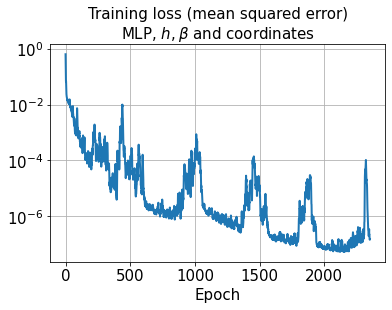

In [78]:
hist = history.history
plt.plot(hist['loss'], lw=2)
#plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, '+ r'$h, \beta$' + ' and coordinates', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
#plt.legend(['Loss (MSE)', 'Validation loss'],loc ='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

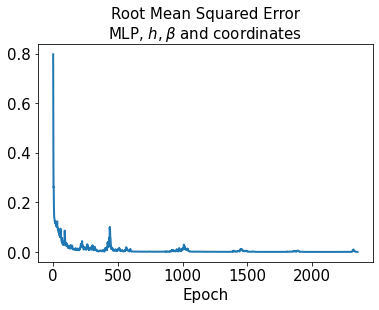

In [76]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, '+ r'$h, \beta$' + ' and coordinates', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

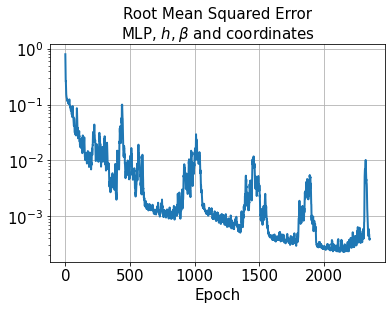

In [77]:
plt.plot(hist['rmse'], lw=2)
#plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, '+ r'$h, \beta$' + ' and coordinates', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
#plt.legend(['RMSE', 'Validation RMSE'],loc ='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [44]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 3.1389e-07 - rmse: 5.6026e-04


In [45]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.6931e-04 - rmse: 0.0130


In [46]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [47]:
model_name = model_directory + "\\20221124steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_hBetaAndCoordinates.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = np.abs(decoded_train - y_train)

In [49]:
error_test_abs = np.abs(decoded_test - y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0006349113396008853


In [52]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.016464143546590877


In [53]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.01233007776106624


In [54]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.00043577528580836483


In [55]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.062307256128702214


In [56]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.01634352439130452


In [57]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [58]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [59]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [60]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [61]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [62]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

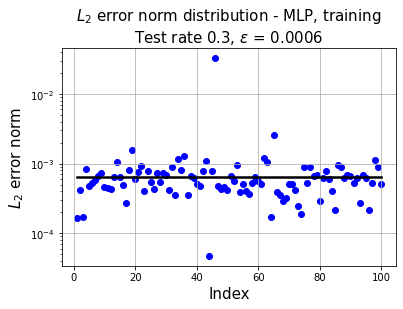

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

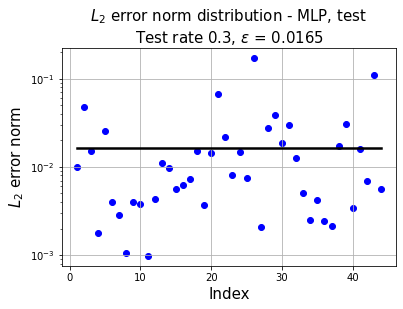

In [64]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

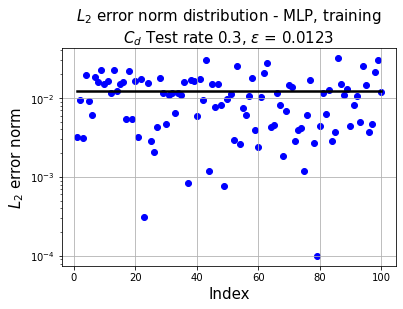

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

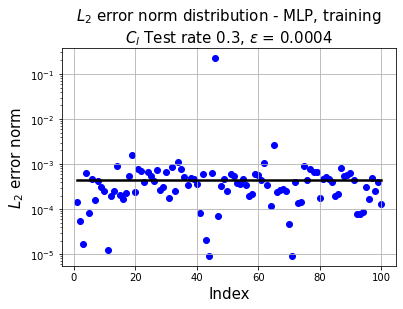

In [66]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

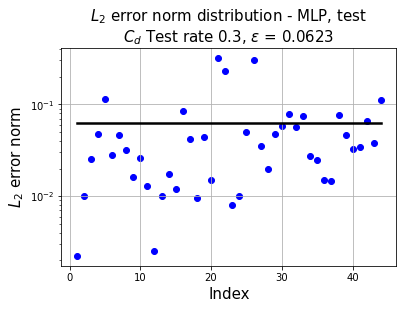

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

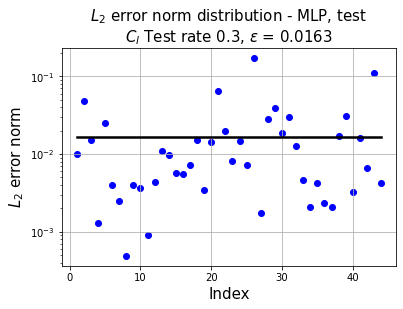

In [68]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [79]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))
aa = aa*np.max(alpha)

In [80]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 15ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0141, L2 error of Cl: 0.0019


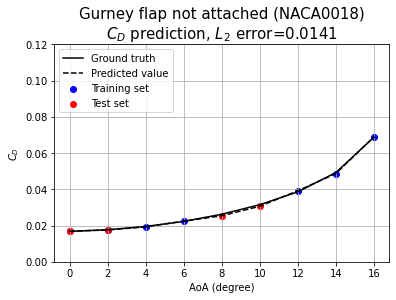

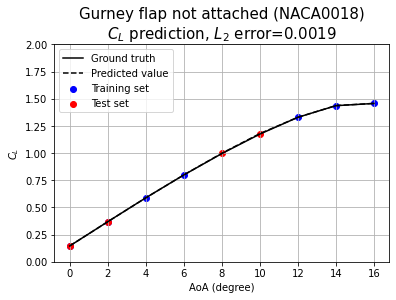

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0184, L2 error of Cl: 0.0023


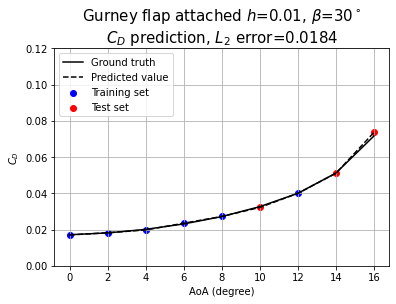

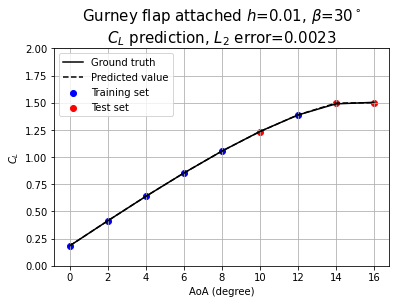

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0388, L2 error of Cl: 0.0033


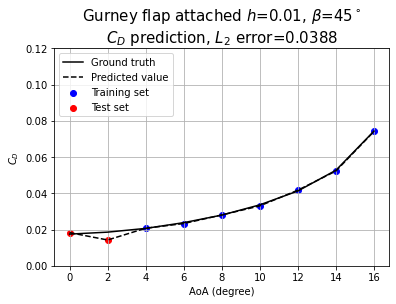

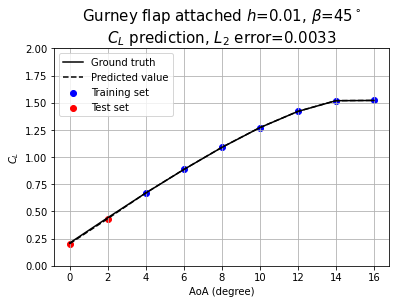

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0439, L2 error of Cl: 0.0101


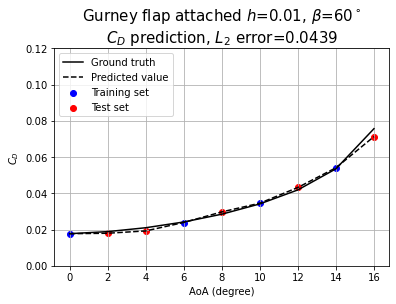

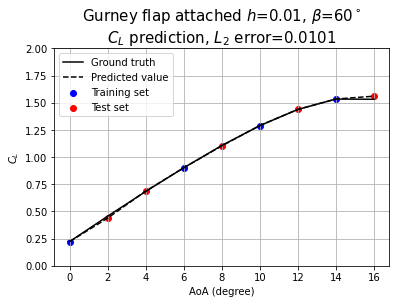

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0318, L2 error of Cl: 0.0149


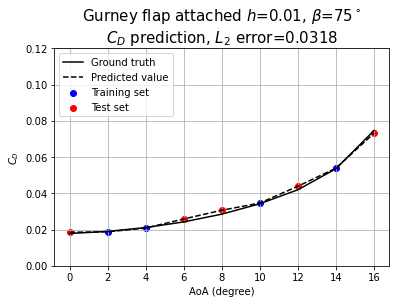

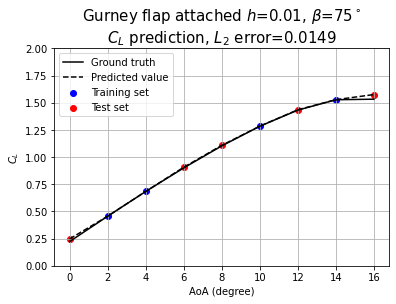

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0871, L2 error of Cl: 0.0129


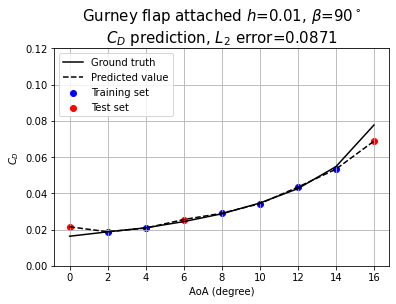

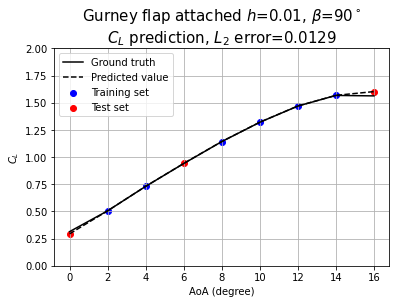

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0129, L2 error of Cl: 0.0025


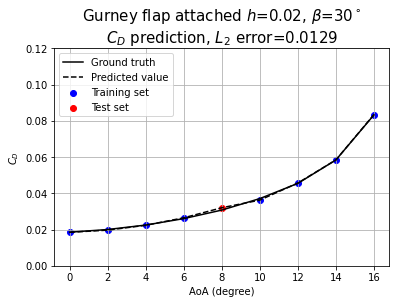

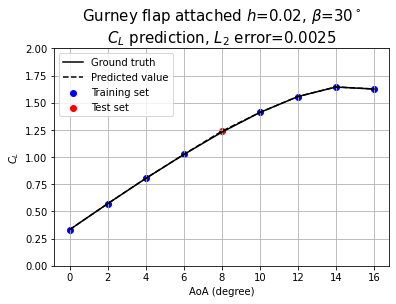

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0158, L2 error of Cl: 0.0042


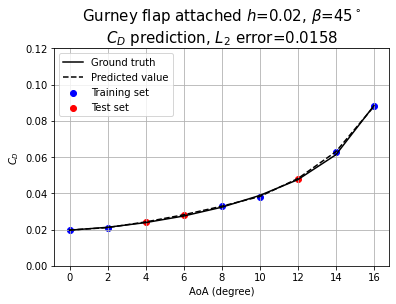

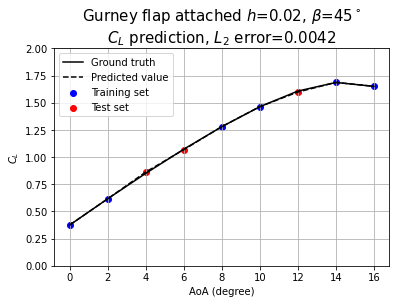

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0120, L2 error of Cl: 0.0041


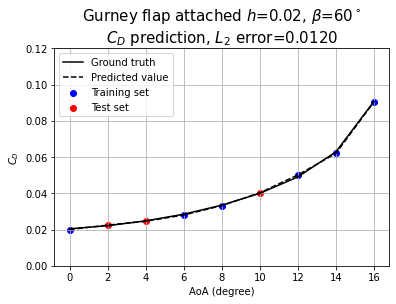

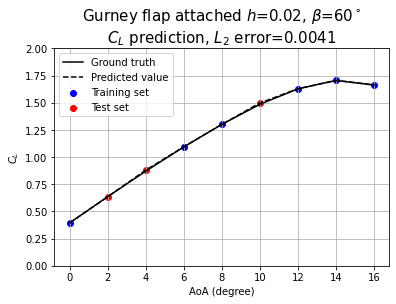

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0118, L2 error of Cl: 0.0055


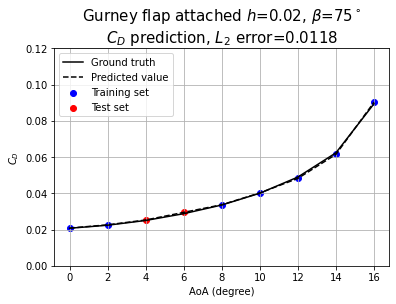

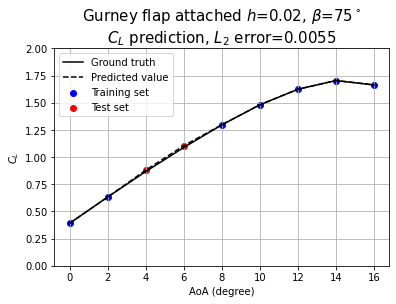

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0483, L2 error of Cl: 0.0209


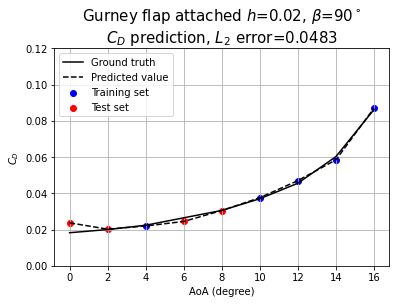

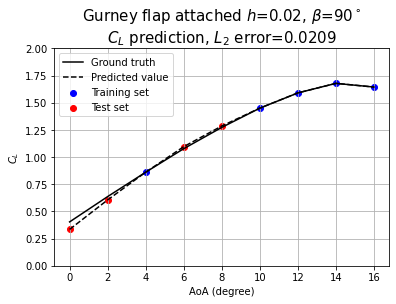

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0143, L2 error of Cl: 0.0053


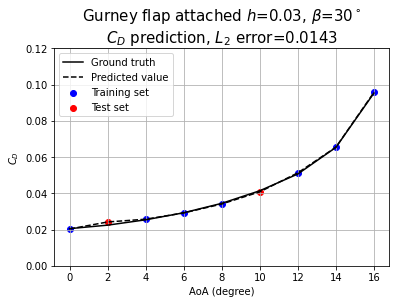

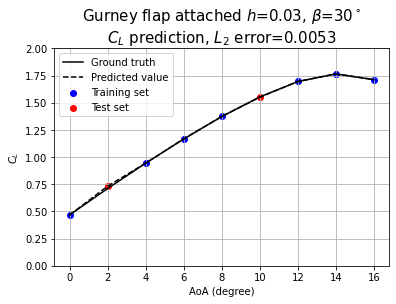

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0243, L2 error of Cl: 0.0041


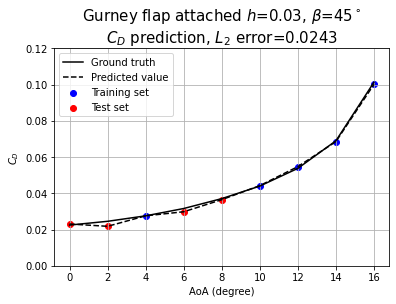

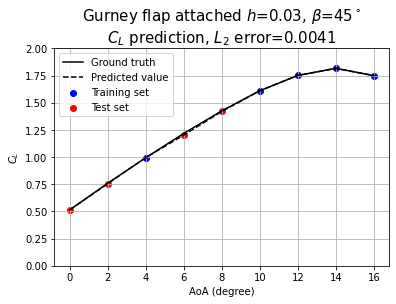

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0176, L2 error of Cl: 0.0019


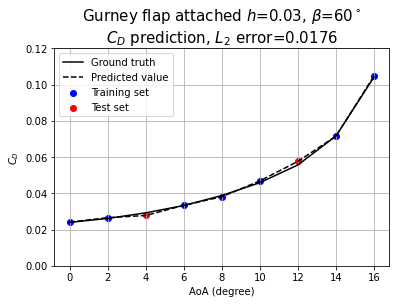

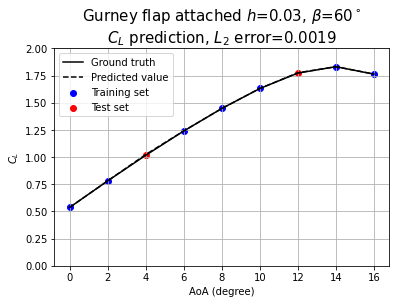

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0154, L2 error of Cl: 0.0066


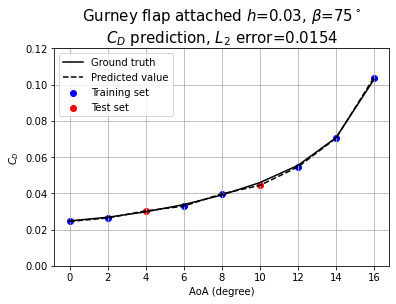

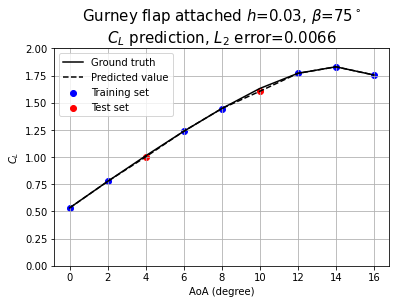

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0156, L2 error of Cl: 0.0039


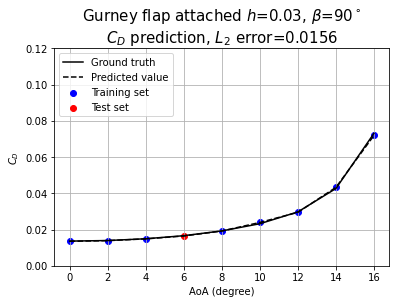

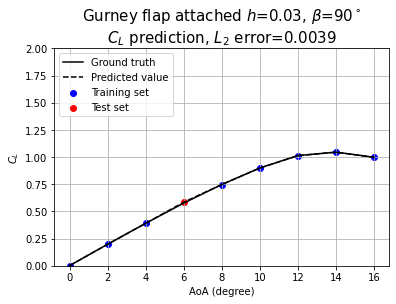

In [86]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]
    aTest = np.array(alpha_test)[:,0]
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, $L_2$ error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_L$ prediction, $L_2$ error=%.4f' % l2_error_Cl, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_NACA0018.jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached $h$=%.2f, '%h[i] +r'$\beta$=%d$^\circ$'% beta[i]+'\n$C_D$ prediction, $L_2$ error=%.4f'%l2_error_Cd,
                  fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap attached $h$=%.2f, '%h[i] +r'$\beta$=%d$^\circ$'% beta[i]+'\n$C_L$ prediction, $L_2$ error=%.4f'%l2_error_Cl,
                  fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()